In [1]:
import numpy
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import sys
sys.path.append('../')
from utils import image_processing

In [32]:
## Change all the paths here
data_path = "C:/Users/wjtay/Documents/GitHub/CS701/public/train_label.txt"  ## Path to train_label.txt
img_dir = "C:/Users/wjtay/Documents/GitHub/CS701/public/img_dir/train/"
test_dir = "C:/Users/wjtay/Documents/GitHub/CS701/public/img_dir/test1/"
label_dir = "C:/Users/wjtay/Documents/GitHub/CS701/notebook/submission/submission/pseudo_label/"
class_dict_path = 'C:/Users/wjtay/Documents/GitHub/CS701/notebook/classes.txt' 
notebook_dir = 'C:/Users/wjtay/Documents/GitHub/CS701/notebook/' ## Path containing notebook

In [33]:
## Run this block to generate mapping between class name and number
classes_dict = {}
for line in open(class_dict_path):
    parts = line.strip().split(' ')
    classes_dict.update({int(parts[0]) : parts[1]})

print(classes_dict)

{1: 'candy', 2: 'egg', 3: 'french', 4: 'chocolate', 5: 'biscuit', 6: 'popcorn', 7: 'pudding', 8: 'ice', 9: 'cheese', 10: 'cake', 11: 'wine', 12: 'milkshake', 13: 'coffee', 14: 'juice', 15: 'milk', 16: 'tea', 17: 'almond', 18: 'red', 19: 'cashew', 20: 'dried', 21: 'soy', 22: 'walnut', 23: 'peanut', 24: 'egg', 25: 'apple', 26: 'date', 27: 'apricot', 28: 'avocado', 29: 'banana', 30: 'strawberry', 31: 'cherry', 32: 'blueberry', 33: 'raspberry', 34: 'mango', 35: 'olives', 36: 'peach', 37: 'lemon', 38: 'pear', 39: 'fig', 40: 'pineapple', 41: 'grape', 42: 'kiwi', 43: 'melon', 44: 'orange', 45: 'watermelon', 46: 'steak', 47: 'pork', 48: 'chicken', 49: 'sausage', 50: 'fried', 51: 'lamb', 52: 'sauce', 53: 'crab', 54: 'fish', 55: 'shellfish', 56: 'shrimp', 57: 'soup', 58: 'bread', 59: 'corn', 60: 'hamburg', 61: 'pizza', 62: 'hanamaki', 63: 'wonton', 64: 'pasta', 65: 'noodles', 66: 'rice', 67: 'pie', 68: 'tofu', 69: 'eggplant', 70: 'potato', 71: 'garlic', 72: 'cauliflower', 73: 'tomato', 74: 'kelp

In [26]:
## Run this block to generate 2 dictionaries
# by_name {'imagename' : [classes]}
# by_label {class_label : [imagename]}
by_name = {}
by_label = {k: [] for k in range(104)}
for line in open(data_path):
    parts = line.strip().split(' ')
    name = parts[0].split('.')[0] + '.jpg'
    labels = [int(x) for x in parts[1:]]
    by_name.update({name: labels})

    for label in labels:
        by_label.get(label).append(name)

 

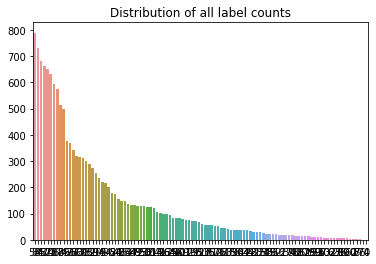

In [27]:
keys = sorted(by_label, key=lambda k: len(by_label[k]), reverse=True)
values = [len(by_label[k]) for  k in keys]
ax = sns.barplot(x=keys, y=values, order=keys)
plt.title('Distribution of all label counts')
plt.show()

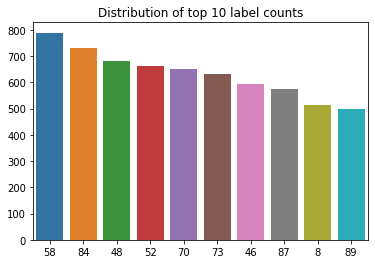

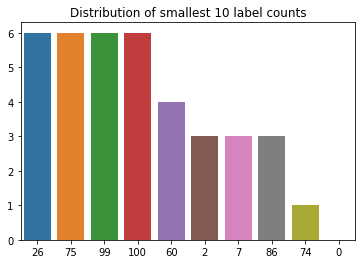

In [5]:
ax = sns.barplot(x=keys[:10], y=values[:10], order=keys[:10])
plt.title('Distribution of top 10 label counts')
plt.show()

ax = sns.barplot(x=keys[-10:], y=values[-10:], order=keys[-10:])
plt.title('Distribution of smallest 10 label counts')
plt.show()

In [ ]:
## Coocurence matrix
occ = list(by_name.values())
df = pd.DataFrame(occ).stack().rename('val').reset_index().drop(columns='level_1')

df = df.merge(df, on='level_0').query('val_x != val_y')
coocur = pd.crosstab(df.val_x, df.val_y)

sns.heatmap(coocur)
plt.title('Co-occurence matrix')
plt.show()

In [ ]:
from collections import Counter
lengths = [len(by_name[k]) for k in list(by_name.keys())]
counts = Counter(lengths)

ax = sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title('Distribution of number of labels per image')
plt.show()

# Probably not very useful

In [ ]:
from tensorflow.keras.preprocessing import image

train_imgs = [fn for fn in os.listdir(img_dir) if fn.endswith('.jpg')]
select_norm = np.random.choice(train_imgs, 6, replace = False)
fig = plt.figure(figsize = (8,6))

for i in range(6):
    
    fp = f'{img_dir}{select_norm[i]}'
    label = by_name.get(select_norm[i])

    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='rgb')
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

In [60]:
size_images = dict()
size_occur = dict()

for dirpath, _, filenames in os.walk(img_dir):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, height = img.size
            size_images.update({path_image: {'width': width, 'height': height}})

            if(size_occur.get((width,height)) == None):
                size_occur.update({(width,height) : 1})
            else:
                size_occur.update({(width, height): size_occur.get((width, height)) + 1})

print(len(size_occur))




799


In [26]:
size_occur[(512, 384)]

995

[(512, 384), (256, 256), (3264, 2448), (512, 341), (410, 273), (642, 428), (410, 307), (640, 428), (307, 204), (512, 340)]


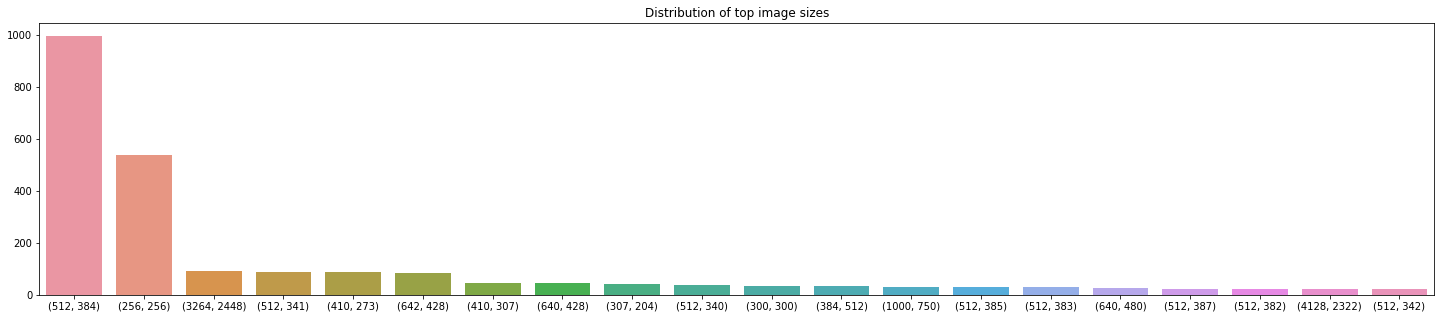

In [52]:
keys = sorted(size_occur, key=lambda k: size_occur[k], reverse=True)
x_axis = [str(v) for v in keys]
print(keys[:10])
values = [size_occur[k] for k in keys]
# print(values)
plt.figure(figsize=(25,5))
ax = sns.barplot(x=x_axis[:20], y=values[:20])
plt.title('Distribution of top image sizes')

plt.show()

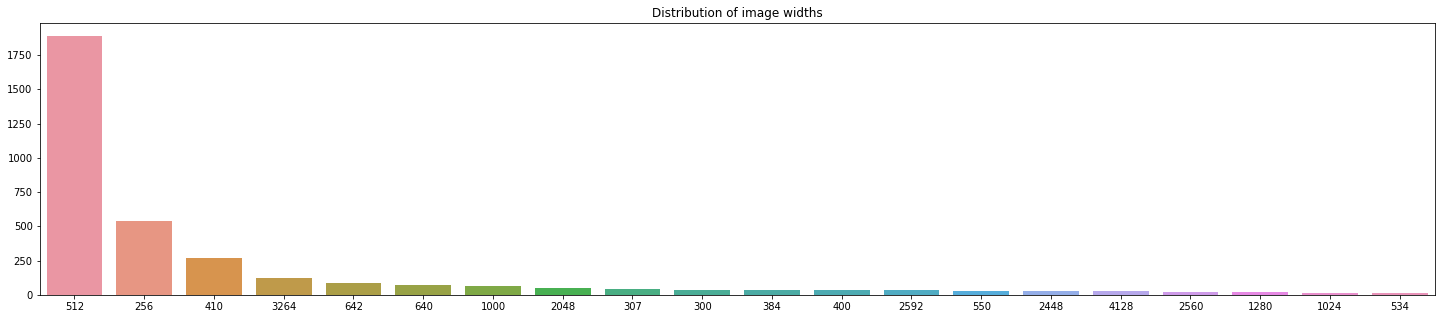

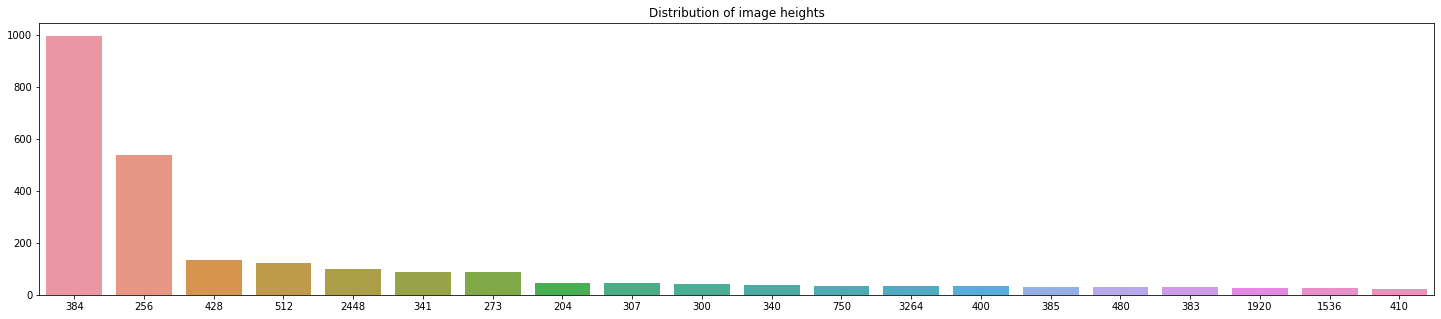

In [78]:
# widths = [size_occur[k]['width'] for k in size_occur.keys()]
widths = [size_images[k]['width'] for k in size_images.keys()]
widths_count = Counter(widths).most_common(20)
x_widths_count = list(list(zip(*widths_count))[0])
y_widths_count = list(list(zip(*widths_count))[1])

heights = [size_images[k]['height'] for k in size_images.keys()]
heights_count = Counter(heights).most_common(20)
x_heights_count = list(list(zip(*heights_count))[0])
y_heights_count = list(list(zip(*heights_count))[1])

plt.figure(figsize=(25,5))
ax = sns.barplot(x=x_widths_count, y=y_widths_count, order=x_widths_count)
plt.title('Distribution of image widths')
plt.show()

plt.figure(figsize=(25,5))
ax = sns.barplot(x=x_heights_count, y=y_heights_count, order=x_heights_count)
plt.title('Distribution of image heights')
plt.show()

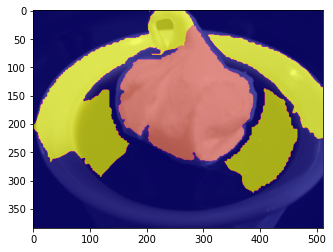

In [157]:
## Viewing image segmentation mask using matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img_name = '00006356' ## Change image name here
img = mpimg.imread(img_dir + img_name + '.jpg') ## Directory paths should be set above already
plt.imshow(img)

img2 = mpimg.imread(label_dir + img_name + '.png')
plt.imshow(img2, alpha=0.7, cmap='plasma')
plt.show()

(-0.5, 1599.5, 1199.5, -0.5)

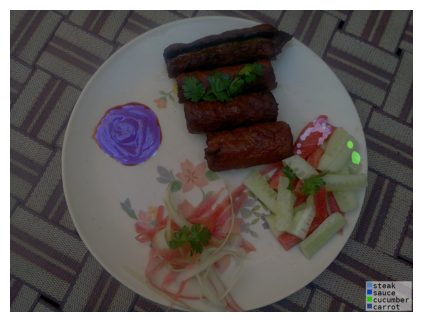

In [159]:
## Viewing segmentation masks using imgviz 
import imgviz
img_name = '00003844' ## Change the image name here
# '00001068'
image1 = Image.open(img_dir + img_name + '.jpg')
rgb = np.array(image1)

image2 = Image.open(label_dir + img_name + '.png')
label = np.array(image2)
# label_resize = imgviz.resize(label, height=rgb.shape[0], width=rgb.shape[1])

label_names = classes_dict

## Generate masks - change legend size using font_size
labelviz_withname2 = imgviz.label2rgb(label, label_names=label_names, font_size=25, loc="rb")  ## Mask on black background
labelviz_withimg = imgviz.label2rgb(label=label, image=rgb, label_names=label_names, font_size=30, loc='rb') ## Mask on top of original image
# labelviz_withimg = imgviz.label2rgb(label=label, image=rgb)

plt.figure(dpi=100)
plt.imshow(labelviz_withimg)
# plt.imshow(labelviz_withname2, alpha=0.5) ## Change alpha for transparency
plt.axis("off")

## Plotting the mask with original image
# plt.subplot(131)
# plt.title("+img")
# plt.imshow(labelviz_withimg)
# plt.axis("off")

## Plotting the mask with black background
# plt.subplot(133)
# plt.title("loc=rb")
# plt.imshow(labelviz_withname2)
# plt.axis("off")


In [160]:
img_name = '00003844' ## Change the image name here
image2 = Image.open(label_dir + img_name + '.png')
image_array = np.array(image2)
labels_in_img = set()
image_array = image_array.flatten()
labels_in_img = set(list(image_array))
print(f'labels_in_img: {labels_in_img}')
print(f"true labels {by_name.get(img_name +'.jpg')}")
for label in by_name.get(img_name +'.jpg'):
    print(classes_dict.get(label))



labels_in_img: {0, 46, 82, 52, 84}
true labels [46, 52, 82, 84, 89]
steak
sauce
cucumber
carrot
cilantro


In [107]:
## Generate differences between the pred data and the true labels
## Check missed_log.txt for the differences
false_pos = dict.fromkeys(range(1,104),0) ## Predicted by model but not in true label
missed_pred = dict.fromkeys(range(1,104),0) ## Not predicted by model but in true label

counter = 0
for file in by_name.keys():
    true_labels = by_name.get(file)
    curr_img = Image.open(label_dir + file[:-4] + '.png')
    image_array = np.array(curr_img)
    image_array = image_array.flatten()

    labels_in_img = set(list(image_array))
    # for row in image_array:
    #     for value in row:
    #         labels_in_img.add(value)
    
    for diff in set(true_labels).difference(labels_in_img):
        if(diff == 0):
            continue
        print(f'{file} -> lables in img :{labels_in_img} true labels: {true_labels}')
        if(diff in labels_in_img):
            false_pos.update({diff: false_pos.get(diff) + 1})
        if(diff in set(true_labels)):
            missed_pred.update({diff: missed_pred.get(diff) + 1})
    
    counter += 1
    if counter % 500 == 0:
        print(counter)

print("False Positive")
print(false_pos)
print("Missed Pred")
print(missed_pred)


## Saving output to pickle file
import pickle
with open(notebook_dir + 'false_p.pickle', 'wb') as handle:
    pickle.dump(false_pos, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(notebook_dir + 'missed_p.pickle', 'wb') as handle:
    pickle.dump(missed_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)


00001068.jpg -> lables in img :{0, 52, 70} true labels: [52, 70, 89]
00002951.jpg -> lables in img :{0, 57, 84, 78} true labels: [57, 78, 84, 89]
00006663.jpg -> lables in img :{0, 66, 68, 82, 28} true labels: [28, 66, 68, 75, 82]
00000631.jpg -> lables in img :{0, 59, 52, 70} true labels: [46, 52, 59, 70]
00000176.jpg -> lables in img :{0, 73, 80, 82, 58, 93} true labels: [46, 58, 73, 80, 82, 93]
00001559.jpg -> lables in img :{0, 8, 58, 30} true labels: [8, 30, 32, 58]
00003254.jpg -> lables in img :{0, 101, 72, 46, 87} true labels: [46, 65, 72, 87, 101]
00003073.jpg -> lables in img :{0, 48, 87} true labels: [48, 66, 87]
00001110.jpg -> lables in img :{0, 8, 84, 89, 58} true labels: [8, 9, 58, 84, 89]
00004114.jpg -> lables in img :{0, 70, 48, 58, 59} true labels: [48, 52, 58, 59, 70]
00003928.jpg -> lables in img :{0, 46, 83, 52, 84, 54, 87} true labels: [37, 46, 52, 54, 83, 84, 87]
00003509.jpg -> lables in img :{0, 47, 52, 59, 95, 31} true labels: [31, 47, 52, 59, 66, 95]
0000653

In [164]:
## If loading from pickle file
with open(notebook_dir + 'false_p.pickle', 'rb') as handle:
    false_pos1 = pickle.load(handle)
with open(notebook_dir + 'missed_p.pickle', 'rb') as handle:
    missed_pred1 = pickle.load(handle)


True

In [126]:
print(f'Total - {sum(missed_pred.values())}')

for item in sorted(missed_pred.items(), key=lambda item: item[1], reverse=True)[0:10]:
    print(f'{classes_dict.get(item[0])}({item[0]}) : {item[1]}')
    

Total - 154
cilantro(89) : 18
lemon(37) : 8
steak(46) : 7
rice(66) : 7
tomato(73) : 7
ice(8) : 5
sauce(52) : 5
lettuce(80) : 5
cucumber(82) : 5
onion(93) : 5


In [127]:
print(classes_dict.get(75))


seaweed


## Still working on more analysis

### Possible Augmentation

Brighten/Lighten the image